In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox_normmax, zscore
from sklearn.pipeline import Pipeline
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, LassoCV
from scipy.stats import zscore
from sklearn.svm import SVR

import warnings

warnings.filterwarnings('ignore')

#### This is my first (somewhat lazy due to time constraints) stab at a regression problem.  I have seen notebooks online where people only used features more closely correlated with the target, which isn't something I wanted to do.  I felt I should use as much of the dataset as possible for the sake of experience. 

#### As I currently have around 3 weeks' worth of practical experience, this is work in progress.  I haven't yet tried it on a holdout test year and that's something I will do upon returning to this project when i've done a couple more projects.  Some group-based imputation could be a good idea (as far as the neighborhood column is concerned), so I will attempt that when I return to this project again in the near future.  At the minute all scores are based on a 30 / 70 split. 

#### Taking the 2008 financial crisis into account could be an exercise in futility.  The housing market was in a speculative bubble from the earliest year in this dataset, and prices didn't drop too much in 2008 here when compared to the rest of the sale dates. 81% of house prices in America were affected by the crisis and that does reflect *slightly* in this dataset, but,not enough to make a huge impact on the result.  Current skill level depicts what else I can do re: this issue right now, so I will make a return to that particular problem further down the line. 

#### All manual ordinal encoding scrapped in favour of being handled by the LabelEncoder, and outlier treatment was also handled automatically. The same few problematic columns (removed by SciKit Learn) arose during the manual data analysis process and automating this feature results in a much smaller project, which takes a lot less time to run, without rendering the hugmass of relplots.  

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Y = train['SalePrice']
train = train.drop(["Id", "SalePrice"], axis = 1)
test = test.drop(["Id"], axis = 1)

In [3]:
train.shape, test.shape, Y.shape

((1460, 79), (1459, 79), (1460,))

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [5]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [7]:
train.skew()

MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
dtype: float64

#### Dropping columns with more than 30% misising values, and dropping any duplicates:

In [8]:
missing_values = train.isnull().sum() * 100 / len(train)
missing_values_df = pd.DataFrame({"Column": train.columns,
                                 "Percent missing": missing_values})

missing_values_df

,Column,Percent missing
MSSubClass,MSSubClass,0.000000
MSZoning,MSZoning,0.000000
LotFrontage,LotFrontage,17.739726
LotArea,LotArea,0.000000
Street,Street,0.000000
...,...,...
MiscVal,MiscVal,0.000000
MoSold,MoSold,0.000000
YrSold,YrSold,0.000000
SaleType,SaleType,0.000000


In [9]:
train = train.dropna(thresh=0.70*len(train), axis=1)

In [10]:
train.drop_duplicates(inplace=True)

#### Log-transform the target variable as it appears to be left-skewed: 

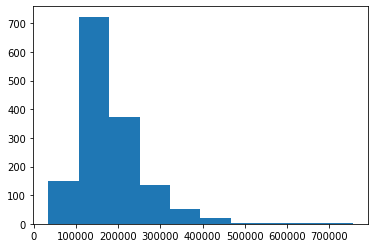

In [11]:
plt.hist(Y)
plt.show() 

In [12]:
Y = np.log(Y)

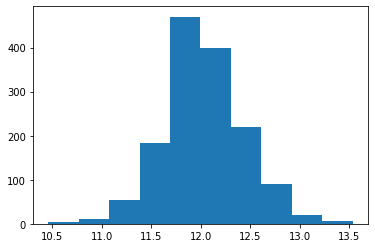

In [13]:
plt.hist(Y)
plt.show() 

#### Get a handle on each unique data type in each column:

In [14]:
for x in train.columns:
    print(f"{x}, {train[x].unique()}\n")

MSSubClass, [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]

MSZoning, ['RL' 'RM' 'C (all)' 'FV' 'RH']

LotFrontage, [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]

LotArea, [ 8450  9600 11250 ... 17217 13175  9717]

Street, ['Pave' 'Grvl']

LotShape, ['Reg' 'IR1' 'IR2' 'IR3']

LandContour, ['Lvl' 'Bnk' 'Low' 'HLS']

Utilities, ['AllPub' 'NoSeWa']

LotConfig, ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']

LandSlope, ['Gtl' 'Mod' 'Sev']

Neighborhood, ['CollgCr' 'Veenke

#### Filling Electrical and MasVnrType with their most common points, the apparent missing data points where the physical feature won't be present (no pool etc.) will be filled with "None" for object columns, and "0" for int columns, respectively:

In [15]:
train["Electrical"].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [16]:
train["MasVnrType"].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [17]:
cols = ["GarageCond", "GarageQual", "GarageFinish", "LotFrontage", "GarageType", "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]
train[cols] = train[cols].fillna("None")
cols = ["GarageYrBlt", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "GarageCars"]
train[cols] = train[cols].fillna(0)
train["Electrical"] = train["Electrical"].fillna("SBrkr")
train["MasVnrType"] = train["MasVnrType"].fillna("None")

#### Drop any columns with high correlation.  In this case I want to drop features over 70%:

In [21]:
corr = train.corr()

In [22]:
plt.figure(figsize=(30, 20))

heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation heatmap', fontdict={'fontsize':18}, pad=12);

In [23]:
correlations = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
correlations

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,NaN,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,-0.140759,...,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
LotArea,NaN,NaN,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,...,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
OverallQual,NaN,NaN,NaN,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,0.308159,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
OverallCond,NaN,NaN,NaN,NaN,-0.375983,0.073741,-0.125694,-0.046231,0.040229,-0.136841,...,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
YearBuilt,NaN,NaN,NaN,NaN,NaN,0.592855,0.311600,0.249503,-0.049107,0.149040,...,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
YearRemodAdd,NaN,NaN,NaN,NaN,NaN,NaN,0.176529,0.128451,-0.067759,0.181133,...,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
MasVnrArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.261256,-0.071330,0.113862,...,0.370884,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317
BsmtFinSF1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.050117,-0.495251,...,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359
BsmtFinSF2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.209294,...,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706
BsmtUnfSF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.183303,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258


In [24]:
to_drop = [x for x in correlations.columns if any(correlations[x] > 0.70)]
to_drop

['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']

In [25]:
train = train.drop(to_drop, axis=1)

#### Feature binning:


In [26]:
train["Bath"] = train["FullBath"] + train["BsmtFullBath"] + 0.5 * (train["BsmtHalfBath"] + train["HalfBath"])
train["Porch"] = train["OpenPorchSF"] + train["EnclosedPorch"] + train["3SsnPorch"] + train["ScreenPorch"]
train["Surface"] = train["GrLivArea"] + train["TotalBsmtSF"]

In [27]:
cols_to_drop = ["GrLivArea", "TotalBsmtSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", 
"FullBath", "BsmtFullBath", "BsmtHalfBath", "HalfBath"]

In [28]:
train = train.drop(cols_to_drop, axis = 1)

#### Treat any time-related features as cyclical:

In [29]:
train["SinMoSold"] = np.sin(2 * np.pi * train["MoSold"] / 12)
train["CosMoSold"] = np.cos(2 * np.pi * train["MoSold"] / 12)

train = train.drop("MoSold", axis=1)

In [31]:
objects = [x for x in train if train[x].dtypes == "object"]

In [32]:
for x in objects:
    le = LabelEncoder() 
    le.fit(list(train[x].values)) 
    train[x] = le.transform(list(train[x].values))

In [33]:
np.where(np.isnan(train))

(array([], dtype=int64), array([], dtype=int64))

In [48]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,MiscVal,YrSold,SaleType,SaleCondition,Bath,Porch,Surface,SinMoSold,CosMoSold
0,0.360392,-0.176855,-0.094172,-0.130845,0.064238,0.750731,0.331412,-0.02618,0.602671,-0.235293,...,-0.069195,-0.190138,0.138777,0.381406,0.012939,1.642256,0.093474,0.114215,1.331523,1.266956
1,-1.085972,-0.176855,0.477754,0.115756,0.064238,0.750731,0.331412,-0.02618,-0.581889,-0.235293,...,-0.069195,-0.190138,-0.614439,0.381406,0.012939,0.368581,-1.177244,0.060801,0.767903,-0.761516
2,0.360392,-0.176855,0.020213,0.421880,0.064238,-1.378933,0.331412,-0.02618,0.602671,-0.235293,...,-0.069195,-0.190138,0.138777,0.381406,0.012939,1.642256,-0.139862,0.287380,-1.541854,0.524484
3,0.591648,-0.176855,-0.284814,0.105669,0.064238,-1.378933,0.331412,-0.02618,-1.875166,-0.235293,...,-0.069195,-0.190138,-1.367655,0.381406,-2.494160,-0.268257,1.746548,-0.005019,1.331523,1.266956
4,0.360392,-0.176855,0.630268,0.878652,0.064238,-1.378933,0.331412,-0.02618,-0.581889,-0.235293,...,-0.069195,-0.190138,0.138777,0.381406,0.012939,1.642256,0.329213,0.995391,-0.002016,2.009429


#### Flatten any skew and apply StandardScaler:

In [34]:
skew = train.skew(numeric_only = True).abs()
columns = skew[skew > 1].index

for x in columns:
    train[x] = boxcox1p(train[x], boxcox_normmax(train[x] + 1))

columns = train.select_dtypes(np.number).columns
train[columns] = StandardScaler().fit_transform(train[columns])

#### Split and test: 

In [35]:
train.shape, Y.shape

((1460, 65), (1460,))

In [36]:
X = train
Y = Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 7, test_size=.3)

#### Drop outliers here if using LR:

In [37]:
residuals = Y_train - LinearRegression().fit(X_train, Y_train).predict(X_train)
outliers = residuals[np.abs(zscore(residuals)) > 3].index

In [38]:
print(f"Outlier columns:\n {outliers}")

Outlier columns:
 Int64Index([523, 970, 30, 688, 1298, 632, 874, 812, 714, 968, 916, 1423, 588,
            495, 803],
           dtype='int64')


In [39]:
X_train = X_train.drop(outliers)
Y_train = Y_train.drop(outliers)

In [40]:
model = LinearRegression()

model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print ("R^2 is: \n", model.score(X_test, Y_test))


R^2 is: 
 0.9094502032269003


In [41]:
lasso = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso.fit(X_train, Y_train)

print(f"Best Lasso alpha: {lasso.alpha_}")
print(f"Training score: {lasso.score(X_train, Y_train)}")
print(f"Test score: {lasso.score(X_test, Y_test)}")

Best Lasso alpha: 0.000774263682681127
Training score: 0.9414072574664087
Test score: 0.9110304105935


In [42]:
ensembles = [('ScaledAdaBoost', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])),
            ('ScaledGradientBoost', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])),
            ('ScaledRandomForest', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators = 10))])),
            ('ScaledExtraTrees', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators = 10))]))]

In [43]:
results = []
names = []

for name, model in ensembles:
  kfold = KFold(n_splits = 10, random_state = 7, shuffle=True)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring = "neg_mean_squared_error")
  results.append(cv_results)
  names.append(name)
  
  print(f"{name}: {round(cv_results.mean(), 5)}, {round(cv_results.std(), 5)}")
  

ScaledAdaBoost: -0.01951, 0.00333
ScaledGradientBoost: -0.01117, 0.00267
ScaledRandomForest: -0.0172, 0.00403
ScaledExtraTrees: -0.01587, 0.0044


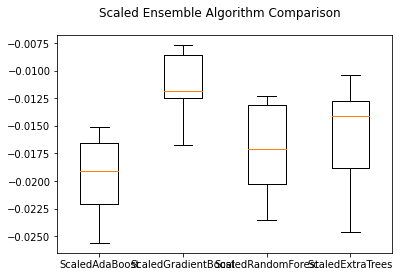

In [44]:
fig = plt.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison') 
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [45]:
scaler = StandardScaler().fit(X_train)

rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
kfold = KFold(n_splits = 10, random_state = 7, shuffle=True)
grid = GridSearchCV(estimator = GradientBoostingRegressor(random_state=7), param_grid = param_grid,
                    scoring="neg_mean_squared_error", cv=kfold)

grid_result = grid.fit(rescaledX, Y_train)

In [46]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 

-0.012868 (0.003040) with: {'n_estimators': 50}
-0.011131 (0.002691) with: {'n_estimators': 100}
-0.010777 (0.002404) with: {'n_estimators': 150}
-0.010592 (0.002233) with: {'n_estimators': 200}
-0.010551 (0.002259) with: {'n_estimators': 250}
-0.010594 (0.002262) with: {'n_estimators': 300}
-0.010575 (0.002289) with: {'n_estimators': 350}
-0.010528 (0.002281) with: {'n_estimators': 400}
Best: -0.010528 using {'n_estimators': 400}


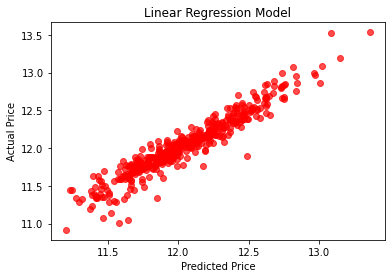

In [47]:
plt.scatter(predictions, Y_test, alpha=.7,
            color='r') 
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d8352123-0526-41ae-8fc6-d4a9aab2194e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>